# Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.

## Задача    
Приоритезировать гипотезы, запустить A/B-тест и проанализировать результаты.

## Описание данных
`hypothesis.csv`:    
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.    


`orders.csv`:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.    


`visitors.csv`:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста



# Импорт библиотек

In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Импорт и изучение данных

In [2]:
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

## hypothesis

In [3]:
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
# поиск дублей
print('Дубликаты: {}'.format(hypothesis.duplicated().sum()))

Дубликаты: 0


In [6]:
# поиск пропусков
print(f'Пропуски:',hypothesis.isna().sum())

Пропуски: Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64


In [7]:
hypothesis.describe()

,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


In [8]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis['hypothesis'] = hypothesis['hypothesis'].str.lower()

In [9]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150 
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


**Вывод:**   
    - дубликаты, пропуски, аномалии = отсутствуют;        
    - регистр букв скорректирован по всей таблице.

## orders

In [10]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [12]:
# поиск дублей
print('Дубликаты: {}'.format(orders.duplicated().sum()))

Дубликаты: 0


In [13]:
# поиск пропусков
print(f'Пропуски:',orders.isna().sum())

Пропуски: transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64


In [14]:
orders.describe()

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


In [15]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [16]:
print('Данные лежат в диапаоне дат от', orders['date'].min(), 'до',
      orders['date'].max())

Данные лежат в диапаоне дат от 2019-08-01 00:00:00 до 2019-08-31 00:00:00


In [17]:
# проверяем, на попадание одного пользователя в несколько групп
orders.loc[(orders['visitorId']).duplicated() == True].head()

,transactionId,visitorId,date,revenue,group
41,2594268419,237748145,2019-08-15,1090,A
91,3176574859,2742574263,2019-08-22,17868,B
95,372616894,457167155,2019-08-22,987,B
98,1962247337,2706377257,2019-08-01,7129,A
112,1638982251,3062433592,2019-08-01,8470,B


In [18]:
list_one = orders.query("group =='A'")['visitorId'].tolist()
list_two = orders.query("group == 'B'")['visitorId'].tolist()
list_three = []
for a in list_one:
    for b in list_two:
        if a == b:
            list_three.append(b)
# оставляем только уникальные.
list_three = set(list_three)
print('Всего пользователй, которые вошли одновременно в сегмент "A" и "B" =', len(list_three))
print('Доля пользователей, которые вошли одновременно в сегмент "A" и "B" = {:.2%}'.format(len(list_three)/len(orders)))

Всего пользователй, которые вошли одновременно в сегмент "A" и "B" = 58
Доля пользователей, которые вошли одновременно в сегмент "A" и "B" = 4.85%


**Вывод:**    
дублей и пустых значений нет. Есть аномалии в revenue.
Потребовалось скорректиторовать формат даты.    
Но есть пользователи, которые относятся к группе A и B. Всего скорее это штатные сотрудники, которые тестировали работоспособность перед запуском. Удалять их не будем, так как они могут повлиять на дальнейшие результаты проекта. Но в "реальной жизни" их лучше удалять.

Всего таких пользователей: 58 шт.    
Доля от общего кол-ва данных: 4.85%.

## visitors

In [19]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [20]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [21]:
# поиск пропусков
print(f'Пропуски:', visitors.isna().sum())

Пропуски: date        0
group       0
visitors    0
dtype: int64


In [22]:
# поиск дублей
print('Дубликаты: {}'.format(visitors.duplicated().sum()))

Дубликаты: 0


In [23]:
visitors.describe()

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


In [24]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [25]:
print('Данные лежат в диапаоне дат от', visitors['date'].min(), 'до',
      visitors['date'].max())

Данные лежат в диапаоне дат от 2019-08-01 00:00:00 до 2019-08-31 00:00:00


**Вывод:**   
аномалий, дублей и пустых значений нет. Потребовалось скорректиторовать формат даты.    
Диапазон дат заказов и визитов совпадает.


# Приоритизация гипотез
## ICE

Рассчитать ICE, отсортировать по убыванию приоритета.    
Формула: ICE = (impact * confidence) / efforts

In [26]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [27]:
hypothesis['ice'] = ((hypothesis['impact'] * hypothesis['confidence']) /
                     hypothesis['efforts']).round(1)
hypothesis.sort_values(by='ice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


## RICE
Рассчитать RICE, отсортировать по убыванию приоритета.    
Формула: ICE = (reach * impact *confidence) / efforts

In [28]:
hypothesis['rice'] = (
    (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) /
    hypothesis['efforts']).round(1)
hypothesis[['hypothesis', 'ice', 'rice']].sort_values(by='rice',
                                                      ascending=False)

,hypothesis,ice,rice
7,"добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2,112.0
2,"добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0,56.0
0,"добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3,40.0
6,"показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0,40.0
8,"запустить акцию, дающую скидку на товар в день рождения",16.2,16.2
3,"изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1,9.0
1,"запустить собственную службу доставки, что сократит срок доставки заказов",2.0,4.0
5,"добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3,4.0
4,"изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0,3.0


## Разница приоритетов

При помощи heatmap отобразим разницу приоритетов, в зависимости от выбранного метода оценивания гипотез

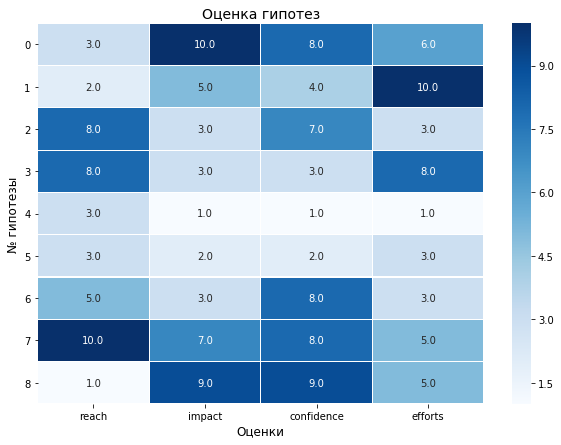

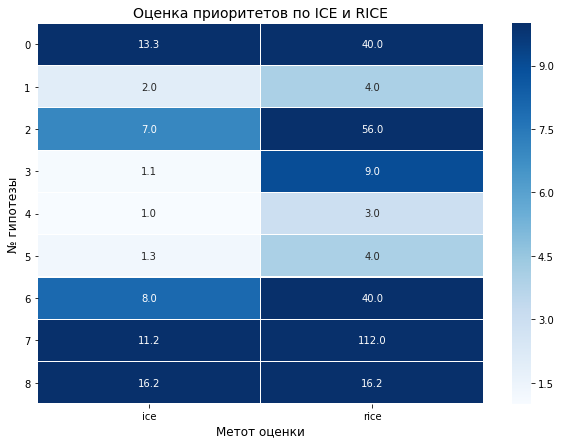

In [29]:
plt.figure(figsize=(10, 7))
ax = sns.heatmap(hypothesis[['reach', 'impact', 'confidence', 'efforts']],
                 fmt='.1f',
                 linecolor='white',
                 cmap="Blues",
                 annot=True,
                 linewidths=0.1,
                 vmax=10)
plt.title('Оценка гипотез', size=14)
ax.set_ylabel('№ гипотезы', size=12)
ax.set_xlabel('Оценки', size=12)
plt.yticks(rotation=0)

plt.show()
plt.figure(figsize=(10, 7))
ax = sns.heatmap(hypothesis[['ice', 'rice']],
                 fmt='.1f',
                 linecolor='white',
                 cmap="Blues",
                 annot=True,
                 linewidths=0.1,
                 vmax=10)
plt.title('Оценка приоритетов по ICE и RICE', size=14)
ax.set_ylabel('№ гипотезы', size=12)
ax.set_xlabel('Метот оценки', size=12)
plt.yticks(rotation=0)
plt.show()

In [30]:
 hypothesis

,hypothesis,reach,impact,confidence,efforts,ice,rice
0,"добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
1,"запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
2,"добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
3,"изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
4,"изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0
5,"добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
6,"показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
7,"добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
8,"запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2


**Вывод:**

По методу ICE наиболее перспективные гипотезы:
 - запустить акцию, дающую скидку на товар в день рождения
 - добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;     
 - добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.     
 
 
Но если использовать метот RICE, который учитывает охват пользователей (Reach), приоритетными становятся:
 - добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;	         
 - добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;     	  
 - добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;     
 - показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.
 
Всё-таки охват пользователей оказывает сильное влияение. В нашем случае у гипотезы <i>`добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`</i> охват = 10, а у гипотезы <i>`добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа`</i>  и <i>`изменить структуру категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар`</i>  = 8. Гипотеза <i>`изменить структуру категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар`</i> не попала в данную выборку, так как она дороже (efforts) 2.6 раза, чем <i>`добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа`</i>.    
Гипотеза <i>`добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей`</i> - оказывает высокое влияние на пользователей, а гипотеза <i>`показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию`	</i> имеет оценку уверенности (confidence) = 8, при том она не является дорогой.    

Для теста советую выбрать следующие гипотезы:    
 - <i>`добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`;</i>      
 - <i>`добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа`;</i>     
 - <i>`добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей`</i>.       
 
Так как по оценкам <i>`добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`</i> и <i>`добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа`</i> имеют высокий охват, а значит мы без проблем найдём нужное количесво трафика. А гипотеза <i>`добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей`</i> дополнит данное тестирование, ведь при успешном тестировании мы получим +30% трафика. Но если у нас проблема с остатками, то стоит выбрать гипотезу <i>`показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию`</i>.

# Анализ A/B-теста
## График кумулятивной выручки по группам

Создадим df `datesGroups` с уникальными парами значений 'date' и 'group', таблицы orders. 
Избавимся от дубликатов.

In [31]:
datesGroups = orders[['date', 'group']].drop_duplicates()
datesGroups.head(2)

,date,group
0,2019-08-15,B
2,2019-08-15,A


Объявляем переменную `ordersAggregated`, содержащую:
 - дату;
 - группу A/B-теста;
 - число уникальных заказов в группе теста по указанную дату включительно;
 - число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
 - суммарную выручку заказов в группе теста по указанную дату включительно.

In [32]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders["date"] <= x["date"], orders[
        "group"] == x["group"])].agg({
            "date": "max",
            "group": "max",
            "transactionId": pd.Series.nunique,
            "visitorId": pd.Series.nunique,
            "revenue": "sum",
        }),
    axis=1,
).sort_values(by=["date", "group"])

Объявляем переменную `visitorsAggregated`, содержащую:     
    - дату;    
    - группу A/B-теста;      
    - количество уникальных посетителей в группе теста по указанную дату включительно.

In [33]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors[
        'group'] == x['group'])].agg({
            'date': 'max',
            'group': 'max',
            'visitors': 'sum'
        }),
    axis=1,
).sort_values(by=['date', 'group'])

Определим переменную `cumulativeData`, объединив `ordersAggregated` и `visitorsAggregated` по колонкам 'date', 'group'

In [34]:
cumulativeData = ordersAggregated.merge(visitorsAggregated,
                                        left_on=['date', 'group'],
                                        right_on=['date', 'group'])
cumulativeData.columns = [
    'date', 'group', 'orders', 'buyers', 'revenue', 'visitors'
]

Объявим переменные `cumulativeRevenueA`, `cumulativeRevenueB`, в которых сохраним данные о датах, выручке и числе заказов в группах A и B.

In [35]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][[
    'date', 'revenue', 'orders'
]]
cumulativeRevenueA.head()

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68
6,2019-08-04,425699,84
8,2019-08-05,549917,109


In [36]:
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][[
    'date', 'revenue', 'orders'
]]

Построим графики кумулятивной выручки по дням и по группам

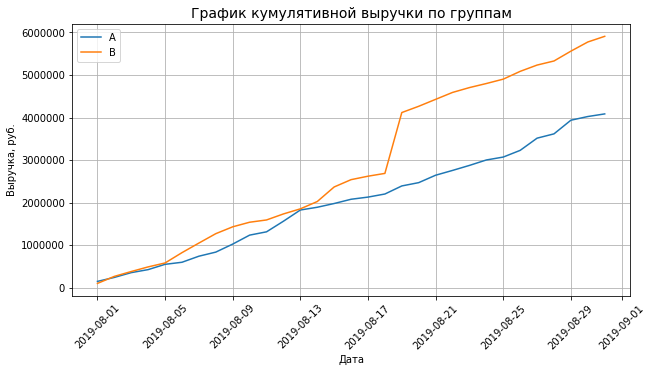

In [37]:
plt.rcParams['figure.figsize'] = (10, 5)
sns.lineplot(cumulativeRevenueA['date'],
             cumulativeRevenueA['revenue'],
             label='A')
sns.lineplot(cumulativeRevenueB['date'],
             cumulativeRevenueB['revenue'],
             label='B')
plt.title('График кумулятивной выручки по группам', size=14)
plt.xlabel("Дата")
plt.ylabel("Выручка, руб.")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

**Вывод:**     
тестрование шло равномерно, но в середине теста сегмент 'B' вырвался вперед и продолжил лидировать.
Это указывает на влияение аномально больших заказов или о всплеске количества заказов.

## График среднего чека по группам

Разделим кумулятивную выручку на кумулятивное число заказов.

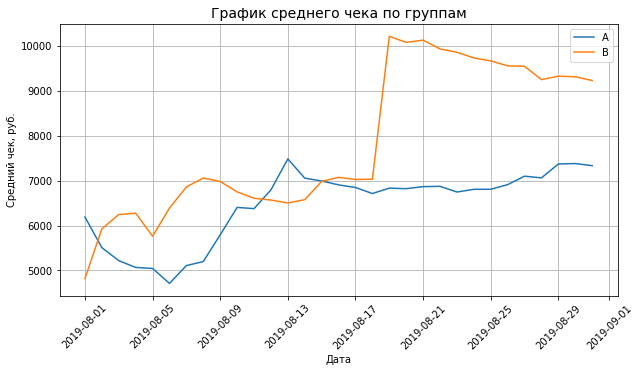

In [38]:
plt.plot(cumulativeRevenueA['date'],
         cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'],
         label='A')
plt.plot(cumulativeRevenueB['date'],
         cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'],
         label='B')
plt.rcParams['figure.figsize'] = (10, 5)
plt.title('График среднего чека по группам', size=14)
plt.xlabel("Дата")
plt.ylabel("Средний чек, руб.")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

**Вывод:**   
2019-08-17 сегмент 'B' сильно вырос, после плавно снижается. Решение по этой метрике принимать рано, нужно сделать анализ выбросов или получить ещё больше данных, чтобы прийти к реальному среднему чеку.

## График относительного различия для среднего чека

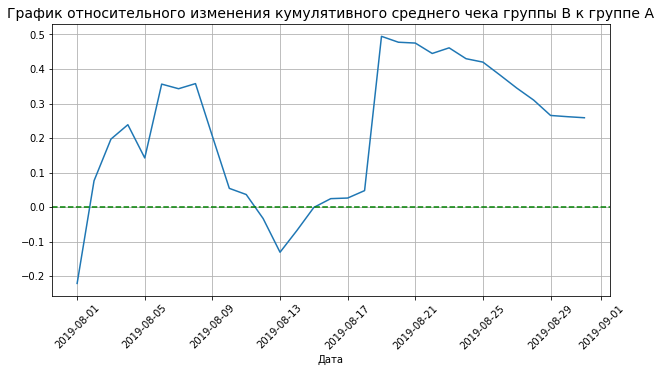

In [39]:
# объеденим таблицы
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                   left_on='date',
                                                   right_on='date',
                                                   how='left',
                                                   suffixes=['A', 'B'])

# построим отношение средних чеков
plt.plot(
    mergedCumulativeRevenue['date'],
    (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB'])
    /
    (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA'])
    - 1)

# добавим ось X
plt.axhline(y=0, color='green', linestyle='--')
plt.rcParams['figure.figsize'] = (10, 5)
plt.title(
    'График относительного изменения кумулятивного среднего чека группы B к группе A',
    size=14)
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.grid()

**Вывод:**   
из-за крупных заказов, график сильно «скачет». Нужно найти их и исключить.

## График кумулятивной конверсии

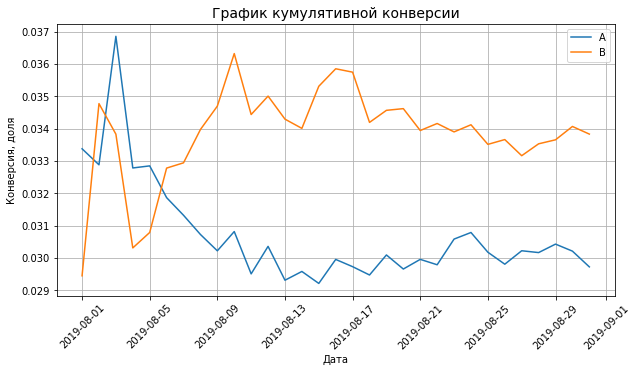

In [40]:
# посчитаем кумулятивную конверсию
cumulativeData[
    'conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

# отделеяем данные на группу A и B
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

# строим графики
plt.rcParams['figure.figsize'] = (10, 5)
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивной конверсии', size=14)
plt.xlabel("Дата")
plt.ylabel("Конверсия, доля")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

**Вывод:**   
    получили ассиметричный график. В начале теста конверсии почти симметричны, затем конверсия группы A резко проседает, а конверсия группы B резко растёт. После данных скачков, конверсии зафиксировались.     
    На момент окончания теста:      
        - конверсия группы А ~ 0.030     
        - конверсия группы B ~ 0.034

In [41]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


## График относительного различия кумулятивных конверсий

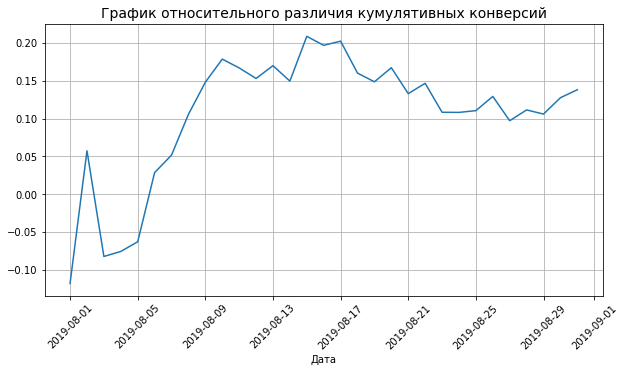

In [42]:
mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']].merge(
    cumulativeDataB[['date', 'conversion']],
    left_on='date',
    right_on='date',
    how='left',
    suffixes=['A', 'B'])
plt.rcParams['figure.figsize'] = (10, 5)
plt.plot(
    mergedCumulativeConversions['date'],
    mergedCumulativeConversions['conversionB'] /
    mergedCumulativeConversions['conversionA'] - 1
)

plt.title('График относительного различия кумулятивных конверсий', size=14)
plt.xlabel("Дата")
plt.xticks(rotation=45)
plt.grid()

**Вывод:**   
начиная с 2019-08-05 группа B уверенно лидирует по конверсии.
Но чтобы сделать более уверенный вывод, в пользу какого-либо сегмента, нужно больше дней теста или выполнить анализ аномалий.

## Точечный график количества заказов по пользователям¶

In [43]:
ordersByUsers = (orders.drop(['group', 'revenue', 'date'], axis=1).groupby(
    'visitorId', as_index=False).agg({'transactionId': pd.Series.nunique}))
ordersByUsers.columns = ['visitorId', 'orders']
print(ordersByUsers.sort_values(by='orders', ascending=False).head())

       visitorId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5


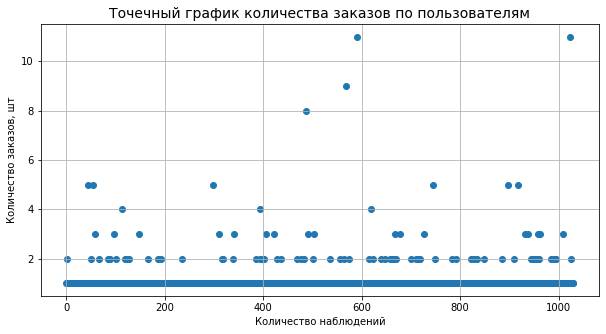

In [44]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечный график количества заказов по пользователям', size=14)
plt.xlabel("Количество наблюдений")
plt.ylabel("Количество заказов, шт")
plt.grid()
plt.show()

**Вывод:**    
много пользователей с 2 и 3 заказами, точная доля их не ясна. Пока непонятно, считать их аномалиями или нет.

## Рассчёт 95-ого и 99-ого перцентиля количества заказов на пользователя

In [45]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

[1. 2. 4.]


**Вывод:**   
не более 5% пользователей оформляли более чем 2 заказа. И только 1% пользователей заказывали более 4 заказов.
Всё что за 99% - является аномалией.

## Точечный график стоимостей заказов

      transactionId   visitorId       date  revenue group
425       590470918  1920142716 2019-08-19  1294500     B
1196     3936777065  2108080724 2019-08-15   202740     B
858       192721366  1316129916 2019-08-27    93940     A
1136      666610489  1307669133 2019-08-13    92550     A
744      3668308183   888512513 2019-08-27    86620     B
682      1216533772  4266935830 2019-08-29    78990     B
662      1811671147  4266935830 2019-08-29    78990     A
743      3603576309  4133034833 2019-08-09    67990     A
1103     1348774318  1164614297 2019-08-12    66350     A
1099      316924019   148427295 2019-08-12    65710     A


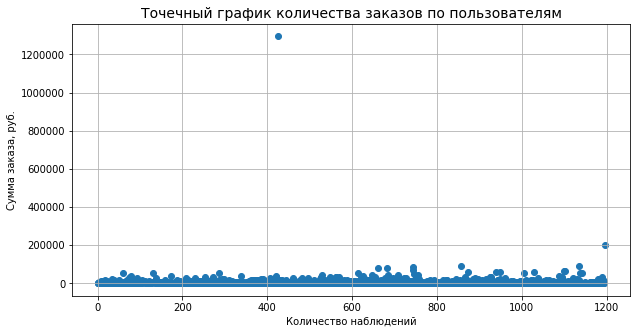

In [46]:
print(orders.sort_values(by='revenue', ascending=False).head(10))
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график количества заказов по пользователям', size=14)
plt.xlabel("Количество наблюдений")
plt.ylabel("Сумма заказа, руб.")
plt.grid()
plt.show()

**Вывод:**   
имеем два выброса.

## Рассчёт 95-й и 99-й перцентили стоимости заказов

In [47]:
print(np.percentile(orders['revenue'], [90, 95, 99]))

[18168.  28000.  58233.2]


**Вывод:**   
имеем 5% заказов на сумму 2800, и 1% заказов на сумму 582233.2. Всё что за 95% - является аномалией

## Статистическая значимость различий в конверсию между группами по «сырым» данным

H0: Конверсия в группе A равна конверсии в группе B     
H1: Конверсия в группе A НЕ равна конверсии в группе B

In [48]:
cumulativeDataA.head(3)

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
2,2019-08-02,A,44,38,242401,1338,0.032885
4,2019-08-03,A,68,62,354874,1845,0.036856


In [49]:
cumulativeDataB.head(3)

,date,group,orders,buyers,revenue,visitors,conversion
1,2019-08-01,B,21,20,101217,713,0.029453
3,2019-08-02,B,45,43,266748,1294,0.034776
5,2019-08-03,B,61,59,380996,1803,0.033833


In [50]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
# visitorsADaily.head()
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
visitorsBDaily.head()

,date,visitorsPerDateB
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


In [51]:
ordersByUsersA = (orders[orders['group'] == 'A'].groupby(
    'visitorId', as_index=False).agg({'transactionId': pd.Series.nunique}))
ordersByUsersA.columns = ['userId', 'orders']
ordersByUsersA.head()

,userId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


In [52]:
ordersByUsersB = (orders[orders['group'] == 'B'].groupby(
    'visitorId', as_index=False).agg({'transactionId': pd.Series.nunique}))
ordersByUsersB.columns = ['userId', 'orders']
ordersByUsersB.head()

,userId,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


In [53]:
sampleA = pd.concat([
    ordersByUsersA['orders'],
    pd.Series(0,
              index=np.arange(visitorsADaily['visitorsPerDateA'].sum() -
                              len(ordersByUsersA['orders'])),
              name='orders')
],
                    axis=0)
sampleB = pd.concat([
    ordersByUsersB['orders'],
    pd.Series(0,
              index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() -
                              len(ordersByUsersB['orders'])),
              name='orders')
],
                    axis=0)

In [54]:
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]))
print('{0:.2%}'.format(sampleB.mean() / sampleA.mean() - 1))

p-value = 0.017
13.81%


**Вывод:**  
p-value = 0.017 меньше 0.05, отвергаем нулевую гипотезу. Анализ по «сырым» данным говорит, что между группами есть статистически значимые различия.      
Относительный прирост конверсии группы B к конверсии группы A = 13.8%

## Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

H0: Средний чек группы A равен среднему чеку группы B     
H1: Средний чек группы A НЕ равен среднему чеку группы B

In [55]:
print('p-value = {0:.3f}'.format(
    stats.mannwhitneyu(orders[orders['group'] == 'A']['revenue'],
                       orders[orders['group'] == 'B']['revenue'], alternative = 'two-sided')[1],))
print('{0:.2%}'.format(orders[orders['group'] == 'B']['revenue'].mean() /
                       orders[orders['group'] == 'A']['revenue'].mean() - 1))

p-value = 0.729
25.87%


**Вывод:**   
p-value больше 0.05 - статистически значимых отличий в среднем чеке между групп нет, принимаем H0. Относительное различие среднего чека между сегментами составляет 25.9%

## Статистическая значимость различий в конверсию между группами по «очищенным» данным

H0: Конверсия в группе A равна конверсии в группе B     
H1: Конверсия в группе A НЕ равна конверсии в группе B

In [56]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders],
                           axis=0).drop_duplicates().sort_values())
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

1099    148427295
928     204675465
684     358944393
648     382846391
1189    393266494
dtype: int64
(59,)


**Вывод:**   
всего 59 аномальных заказа

In [57]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[np.logical_not(
            ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(
            0,
            index=np.arange(visitorsADaily['visitorsPerDateA'].sum() -
                            len(ordersByUsersA['orders'])),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[np.logical_not(
            ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(
            0,
            index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() -
                            len(ordersByUsersB['orders'])),
            name='orders',
        ),
    ],
    axis=0,
)
print('p-value = {0:.3f}'.format(
    stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative='two-sided')[1]))
print('{0:.2%}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-value = 0.018
14.53%


**Вывод:**  
результаты конверсии практически не изменились. p-value меньше 0.05, отвергаем нулевую гипотезу, конверсия в группе A не равна конверсии в группе B.

## Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

H0: Средний чек группы A равен среднему чеку группы B     
H1: Средний чек группы A НЕ равен среднему чеку группы B

In [58]:
print('p-value = {0:.3f}'.format(
    stats.mannwhitneyu(orders[np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)),
    )]['revenue'],
                       orders[np.logical_and(
                           orders['group'] == 'B',
                           np.logical_not(
                               orders['visitorId'].isin(abnormalUsers)),
                       )]['revenue'],
                       alternative='two-sided')[1]))

print("{0:.2%}".format(orders[np.logical_and(
    orders['group'] == 'B',
    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
)]['revenue'].mean() / orders[np.logical_and(
    orders['group'] == 'A',
    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
)]['revenue'].mean() - 1))

p-value = 0.961
-1.38%


**Вывод:**  
p-value больше 0.05, принимаем H0 - средний чек группы A равен среднему чеку группы B.
p-value увеличился, но и разница между сегментами сильно сократилась: 25.9% => -1.4%.

# Общий вывод    

**Изучение и подготовка данных**     

`hypothrsis`:
- дубликаты, пропуски, аномалии = отсутствуют;
- регистр букв скорректирован по всей таблице.      

`orders`:
- дублей и пустых значений нет. Есть аномалии в revenue.
- cкорректирован формат даты;  
- данные лежат в диапазоне дат: 2019-08-01 до 2019-08-31;
- есть пользователи, которые отнесены к группе A и B. Всего скорее это штатные сотрудники, которые тестировали работоспособность перед запуском.     

`visitors`:
- аномалий, дублей и пустых значений нет; 
- скорректирован формат даты;
- диапазон дат заказов и визитов совпадает.

**Гипотезы:**
Анализ гипотез выполнен по методу ICE и RICE.
Для интернет-магазина важен охват, поэтому предпочтительнее выбирать RICE.

Для теста советую выбрать следующие гипотезы:

- добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

**A/B-тест**    


Факты:   
    - есть статистически значимые различия по конверсии между группами по «сырым» и по отфильтрованным данным;    
    - нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по отфильтрованным данным;    
    - график различия конверсии между группами сообщает, что результаты группы A хуже группы B и нет значительной тенденции к улучшению:
    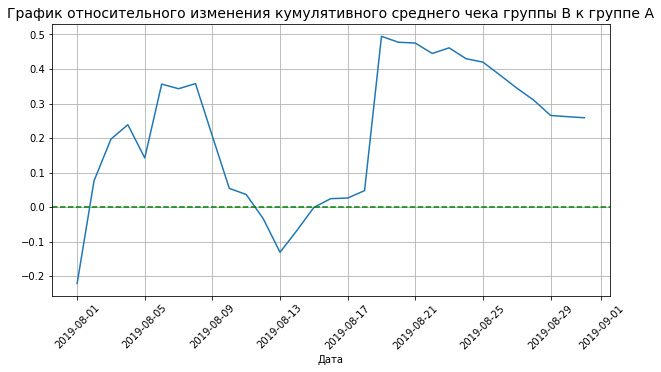
    - график различия среднего чека говорит о том, что результаты группы B лучше, приблизительно на 25%:   
    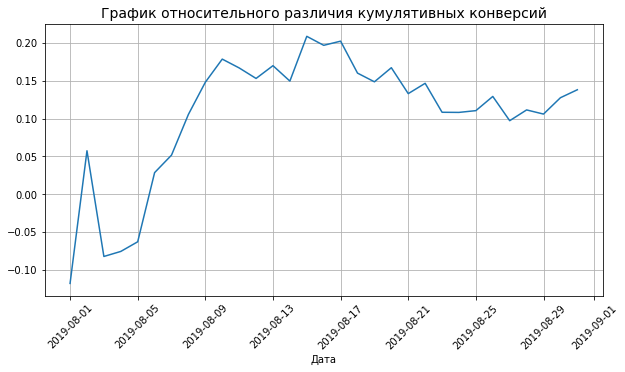
    
Предлагаемое решение: остановить тест, зафиксировать победу группы B. Поздравить команду с успешным увеличем CR на 14.5%.